# Homework #9
### Juan Martin Morelli (N12699038)
### NYU Stern

We want to solve for the risk neutral price when divididends are LQ:

$d_{t}=X^{'}_{t}DX_{t}$ with $D>0$ and $X_{t+1}=AX_{t}+CW_{t+1}$ where $EW_{t+1}W_{t+1}^{'}=\mathcal{I}$.

The solution is $p_{t}=X^{'}_{t}PX_{t}+\delta$, where $\delta=\frac{\beta}{1-\beta}\text{trace}(C'(C+P)C)$ and $P$ is the solution to the Lyapunov equation

$LP=\Lambda P\Lambda^{'} + M$

where $\Lambda=\sqrt{\beta}A^{'}$ and $M=\beta A'DA$.

Hence, for finding the price we first need to solve for the Lyapunov equation.

Then we can apply the formula $p_{t}=X^{'}_{t}PX_{t}+\delta$.

The code below will follow that logic. I will assume that shocks are multivariate normal.

Let's first defie the type for the model: `LQ_Asset_Price`.

In [1]:
using Distributions

type LQ_Asset_Price
    β::Float64 # risk neutral agent's discount factor
    A::Array{Float64,2} # Matrix for state transition
    C::Array{Float64,2} # Matrix for variance
    D::Array{Float64,2} # Matrix for dividends
    tol::Float64 # Tolerance Level
    maxit::Int64 # Maximum iterations
    T::Int64 # Total number of periods
end 

Define a function for the state and the dividends process:

In [2]:
function state_fun(lqap::LQ_Asset_Price,Wt)
    xt = Array(Float64,size(lqap.A,2),size(Wt,2)+1)
    xt[:,1] = zeros(size(xt,1))
    for i_w in 1:lqap.T
        xt[:,i_w+1] = lqap.A*xt[:,i_w] + Wt[:,i_w]
    end
    return xt
end

dt(ap,xt) = xt'ap.D*xt

dt (generic function with 1 method)

Define the Lyapunov Operator and the function `iter` to iterate over it to find a solution to the equation:

In [3]:
L(X,Λ,M) = Λ*X*Λ' + M

function iter(X,lqap::LQ_Asset_Price)
    resid = 1.0
    iteration = 0
    Λ = sqrt(lqap.β)*lqap.A'
    M = lqap.β*lqap.A'*lqap.D*lqap.A
    
    while resid>lqap.tol
        if iteration>lqap.maxit
            break
        else
            X0 = copy(X)
            X = L(X,Λ,M)
            resid = norm(X-X0)
        end
    end
    return X
end

iter (generic function with 1 method)

Define function to compute the stochastic process $W_{t}$. I assume multivariate normal.

In [4]:
function shocks_simul(lqap::LQ_Asset_Price)
    mnrv = MvNormal(eye(size(lqap.C,2)))
    Wt = rand(mnrv,lqap.T)
    return Wt
end

shocks_simul (generic function with 1 method)

Define the function `simul_price` to get the price simulations once we already know the solution to Lyapunov equation and the realizations of the stochastic process.

In [5]:
function simul_price(lqap::LQ_Asset_Price,Wt,P,δ)
    xt = state_fun(lqap,Wt)[:,2:end]
    pt = Array(Float64,lqap.T,1)
    for i_x in 1:lqap.T
        pt[i_x] = (xt[:,i_x]'*P*xt[:,i_x] + δ)[1]
    end
    return pt,xt
end

simul_price (generic function with 1 method)

Check and solve for the Lyapunov Equation:

In [6]:
function lpnv(lqap::LQ_Asset_Price)
    
    rr, = eig(lqap.A)
    if maximum(rr)>=1
        print("Error: spectral radius greater than 1. Lyapunov will not converge.")
        return Void
    end
    
    P = iter(eye(size(lqap.A,2)),lqap)
    δ = (1/(1-lqap.β))*lqap.β*trace(lqap.C'*(lqap.D+P)*lqap.C)
    return P,δ
end

lpnv (generic function with 1 method)

Give keywords and default values to the model:

In [7]:
function LQ_Asset_Price(;β::Float64=.9,
                         A::Array{Float64}=[[.8 -.1];[-.1 .8]],
                         C::Array{Float64}=eye(2),
                         D::Array{Float64}=eye(2),
                         tol::Float64=1.0e-5,
                         maxit::Int64=10_000,
                         T::Int64=100)
    LQ_Asset_Price(β,A,C,D,tol,maxit,T)
end

LQ_Asset_Price

Solve the model:

In [8]:
lqap = LQ_Asset_Price()

P,δ = lpnv(lqap)

Wt = shocks_simul(lqap)

pt,xt = simul_price(lqap,Wt,P,δ)

(
100x1 Array{Float64,2}:
  49.4881
  49.7957
  50.5092
  61.4371
  75.2479
  91.3633
  76.3441
  92.8127
 125.293 
 105.942 
 114.253 
  78.1259
  73.0949
   ⋮     
  50.6069
  52.5142
  54.1121
  55.4777
  50.4376
  53.658 
  51.4969
  49.8888
  55.0543
  50.1418
  58.415 
  69.1272,

2x100 Array{Float64,2}:
 -0.251415  -0.630684   0.25525    1.20766  …  -0.822284  2.71488  4.02888
 -0.377961  -0.353491  -0.662718  -1.77905     -0.510816  1.2292   2.11259)

Check that the code gracefully fails when the spectral radius of matrix A is greater than one:

In [9]:
lqap = LQ_Asset_Price(A=[[3. 1.];[1. 3.]])

P1,δ1 = lpnv(lqap)

Wt1 = shocks_simul(lqap)

pt1, = simul_price(lqap,Wt1,P,δ)

Error: spectral radius greater than 1. Lyapunov will not converge.

LoadError: LoadError: MethodError: `start` has no method matching start(::Type{Void})
while loading In[9], in expression starting on line 3

Finally, plot the contour for the original example. The code for the contour is based on the lectur eon Kalman Filter from QuantEcon.

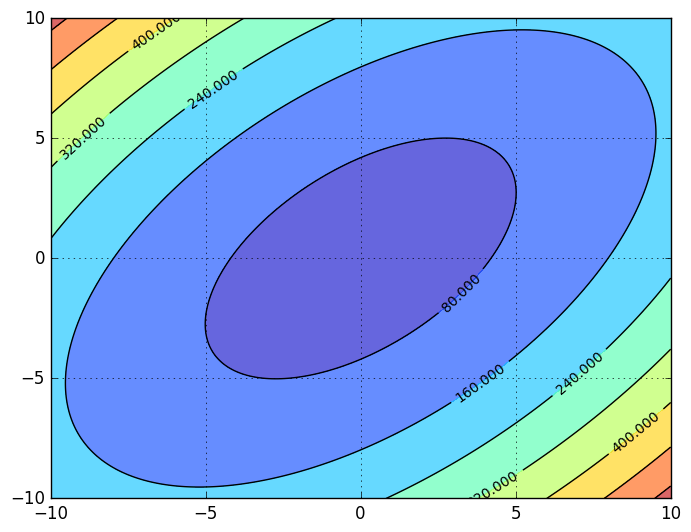

8-element Array{Any,1}:
 PyObject <matplotlib.text.Text object at 0x31d2fe850>
 PyObject <matplotlib.text.Text object at 0x31d273350>
 PyObject <matplotlib.text.Text object at 0x31d2fe650>
 PyObject <matplotlib.text.Text object at 0x31d268310>
 PyObject <matplotlib.text.Text object at 0x31d1c7a90>
 PyObject <matplotlib.text.Text object at 0x31d1e45d0>
 PyObject <matplotlib.text.Text object at 0x31d3cc810>
 PyObject <matplotlib.text.Text object at 0x31d181bd0>

In [35]:
using PyPlot
using QuantEcon

lqap = LQ_Asset_Price()
P,δ = lpnv(lqap)

xt = state_fun(lqap,Wt)[:,2:end]
pt,xt = simul_price(lqap,Wt,P,δ)

# == Set up grid for plotting == #
x1 = linspace(-10,10, 200)
x2 = linspace(-10, 10, 200)
X, Y = meshgrid(x1, x2)

xt_plot = [x1 x2]'

function get_price(xt,P,δ)
    pt = Array(Float64,length(x1),length(x2))
    for i_x1 in 1:length(x1)
        for i_x2 in 1:length(x2)
            pt[i_x1,i_x2] = ([x1[i_x1];x2[i_x2]]'*P*[x1[i_x1];x2[i_x2]] + δ)[1]
        end
    end
    
    return pt
end

# helper function to prepare axis
function prep_ax()
    fig, ax = subplots()
    ax[:xaxis][:grid](true, zorder=0)
    ax[:yaxis][:grid](true, zorder=0)
    return ax
end

function plot1()
    ax = prep_ax()
    Z = get_price(xt_plot,P,δ)
    ax[:contourf](X, Y, Z, 8, alpha=0.6, cmap=ColorMap("jet"))
    cs = ax[:contour](X, Y, Z, 8, colors="black")
    ax[:clabel](cs, inline=1, fontsize=10)
end

plot1()